# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Прикладные задачи анализа данных" </center>

# <center> Лабораторная работа №2. Рекомендательные системы </center>

* В данной лабораторной работе вам предлагается разработать алгоритм рекомендации фильмов.  
* Рекомендацией пользователю будем считать подборку из 10 фильмов.  
* Ожидаемый результат - эти фильмы пользователю понравятся и он высоко их оценит (weak assumption). 

### Задания  
  
1. Выполните разведывательный анализ данных (EDA).  
2. Разработайте алгоритм рекомендации фильмов пользователю. Используйте различные подходы: collaborative filtering (user to user, item to item), content-based, гибридный.  
3. Предложите способ оценки качества алгоритма и оцените качество различных подходов и моделей из предыдущего пункта.  
4. Опишите недостатки и ограничения предложенных вами моделей/алгоритмов и предложите возможные решения для борьбы с ними. 

### Данные 

Данные находятся в архиве `ml-latest-small.zip`.  
Они представляют из себя оценки 9742 фильмов, выставленные 610 пользователями. 
Также для некоторых фильмов известна информация о жанрах в виде тегов.

**Tip:** Вы можете самостоятельно добыть дополнительную информацию о фильмах, используя открытые (или закрытые) источники. Например, данные с IMDb, для взаимодействия с которой есть [специальный модуль](https://github.com/alberanid/imdbpy).  
**NB:** Использование дополнительных данных положительно скажется на оценке.

In [305]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('white')

In [306]:
ratings = pd.read_csv("data/ratings.csv")
links = pd.read_csv("data/links.csv")
movies = pd.read_csv("data/movies.csv")
tags = pd.read_csv("data/tags.csv")

Я пробовал скачать доп данные с IMDb, но на каждый фильм уходило по 1-3 секунды, из-за чего скачать информацию о всех 10к фильмах стало довольно проблематично.

In [307]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [308]:
links.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [309]:
tags.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [310]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [311]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [312]:
tags.describe()

,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09


In [313]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [314]:
ratings.groupby("movieId").mean().sort_values("rating", ascending=False).merge(movies, on="movieId")[["title", "rating"]].head()

,title,rating
0,Paper Birds (Pájaros de papel) (2010),5.0
1,"Act of Killing, The (2012)",5.0
2,Jump In! (2007),5.0
3,Human (2015),5.0
4,L.A. Slasher (2015),5.0


In [315]:
tmp = movies["genres"].str.get_dummies(sep='|')
tmp.head(2)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [316]:
movies_dummy = pd.concat([movies, tmp], axis=1)
movies_dummy.drop("genres", axis = 1, inplace = True)
movies_dummy.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [317]:
movies["ratingCount"] = movies.merge(ratings.groupby('movieId')['rating'].count(), on="movieId", how="left")["rating"]

In [318]:
movies = movies.merge(movies_dummy.drop("title", axis=1), on="movieId", how = "left")

In [319]:
movies = movies.merge(ratings.groupby("movieId").mean()["rating"], on="movieId")

In [320]:
movies[movies["title"].str.contains('\(')==False]

,movieId,title,genres,ratingCount,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
6042,40697,Babylon 5,Sci-Fi,2.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2.25
9013,140956,Ready Player One,Action|Sci-Fi|Thriller,4.0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,3.50
9073,143410,Hyena Road,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.00
9120,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.00
9161,149334,Nocturnal Animals,Drama|Thriller,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3.00
9241,156605,Paterson,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.50
9349,162414,Moonlight,Drama,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.00
9430,167570,The OA,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.00
9496,171495,Cosmos,(no genres listed),2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.50
9497,171631,Maria Bamford: Old Baby,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.00


In [321]:
movies[movies["(no genres listed)"]==1]

,movieId,title,genres,ratingCount,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
8499,114335,La cravate (1957),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.000000
8666,122888,Ben-hur (2016),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.500000
8669,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),7.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.785714
8764,129250,Superfast! (2015),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.500000
8818,132084,Let It Be Me (1995),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.500000
8884,134861,Trevor Noah: African American (2013),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.500000
9015,141131,Guardians (2016),(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.500000
9035,141866,Green Room (2015),(no genres listed),3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.333333
9052,142456,The Brand New Testament (2015),(no genres listed),2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.000000
9073,143410,Hyena Road,(no genres listed),1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.000000


In [322]:
def parse_title(row):
    yearStart = int(row["title"].rfind("("))
    yearEnd = int(row["title"].rfind(")"))
    if(yearStart!=-1 and yearEnd!=-1):
        year = row["title"][yearStart+1: yearEnd]
        if(year.isdigit()):
            return int(year)
        else:
            return int(-1)
    else:
        return int(-1)
def drop_year(row):
    yearStart = int(row["title"].rfind("("))
    if(yearStart!=-1):
        return row["title"][0:yearStart-1]
    else:
        return row["title"]

In [323]:
movies["year"] = movies.apply(lambda x: parse_title(x), axis=1)

In [324]:
movies[movies["year"]!=-1]["year"].describe()

count    9711.000000
mean     1994.659973
std        18.492137
min      1902.000000
25%      1988.000000
50%      1999.000000
75%      2008.000000
max      2018.000000
Name: year, dtype: float64

In [325]:
movies["title"] = movies.apply(lambda x: drop_year(x), axis=1)

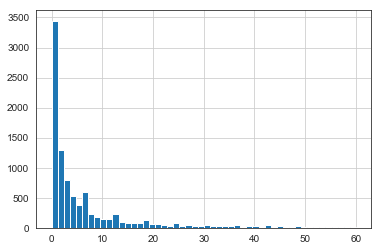

In [326]:
movies["ratingCount"].hist(bins=50, range=(0, 60)) #для большей наглядности смотрим до 60, иначе хвост будет дилнный

Очень большое количество фильмов имеет мало оценок.

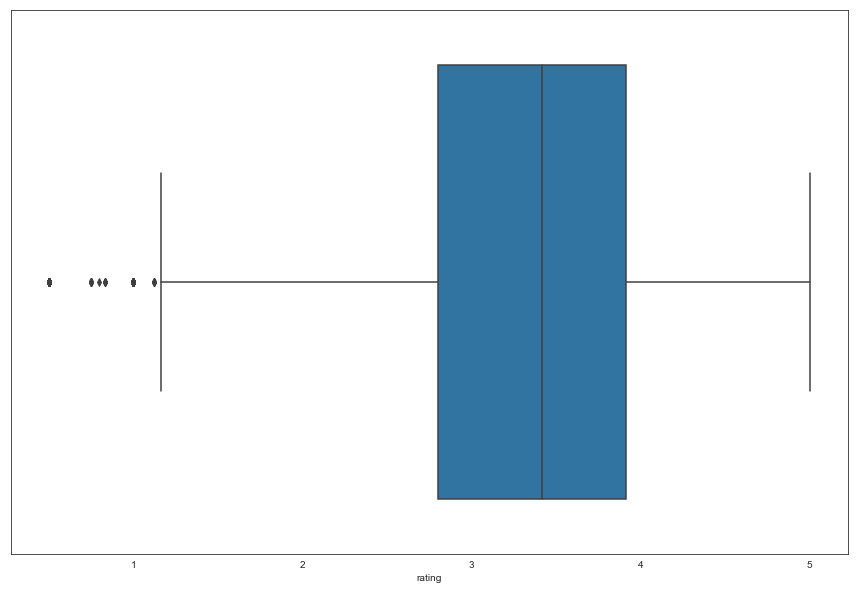

In [327]:
plt.subplots(figsize=(15,10))
sns.boxplot(movies["rating"], orient="h")
ax.title.set_text("Распределение рейтингов фильмов")

In [328]:
movies[movies["year"]==-1]["movieId"]

6042     40697
9013    140956
9073    143410
9120    147250
9161    149334
9241    156605
9349    162414
9430    167570
9496    171495
9497    171631
9500    171749
9507    171891
9593    176601
Name: movieId, dtype: int64

Посмотрим сколько фильмов выпускалось каждый год.

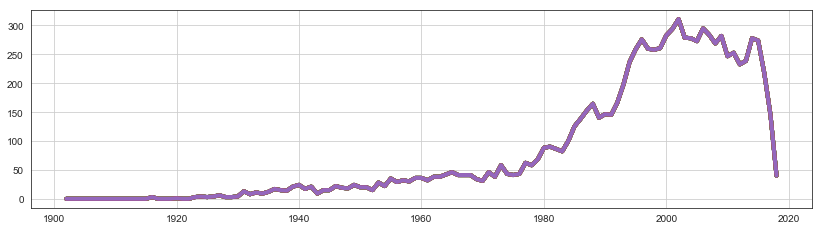

In [329]:
quant=movies[movies['year']!=-1]
fig1, ax1 = plt.subplots(1,1,figsize=(14,8))
plt.subplot(211)
plt.plot(quant.groupby(['year']).count(), linewidth=4.0)
plt.grid(True)

Заметно, что с 1920 по 1970 фильмы выпускались примерно с одинаковой скоростью, но после 1970 произошел заметный скачок. В 2015 сильное падение из-за недостатка данных.

Теперь посмотрим на оценки юзеров!

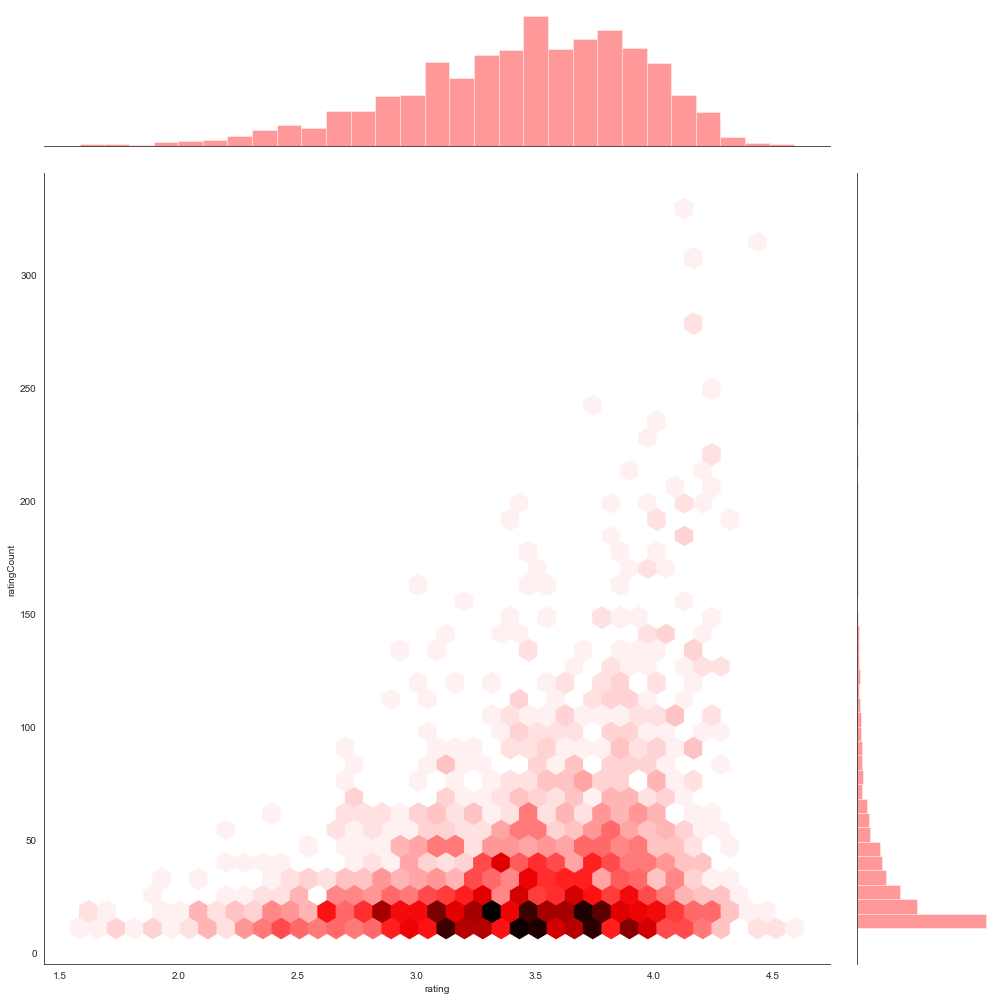

In [330]:
sns.jointplot(x='rating',y='ratingCount', data=movies[movies["ratingCount"]>10], height=14, color='red', kind="hex")

Видно, что самые оцениваемые фильмы имеют оценку выше 4, сто проц этим фильмам единиц понаставили конкуренты и хейтеры.

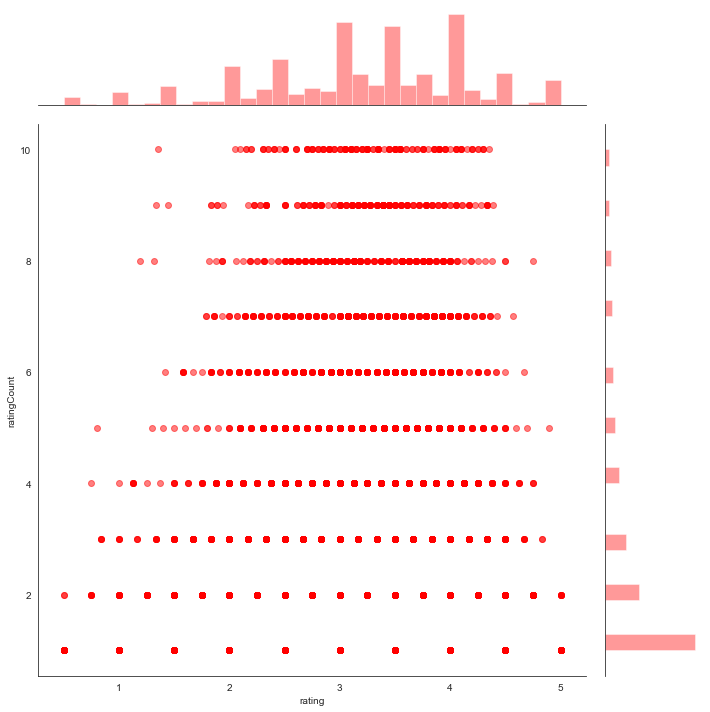

In [331]:
sns.jointplot(x='rating',y='ratingCount', data=movies[movies["ratingCount"]<=10], alpha=0.5, height=10, color='red')

какая-то ерунда на графике выше, пусть будет немного бреда.

In [332]:
genres = set(movies.columns[5:24])

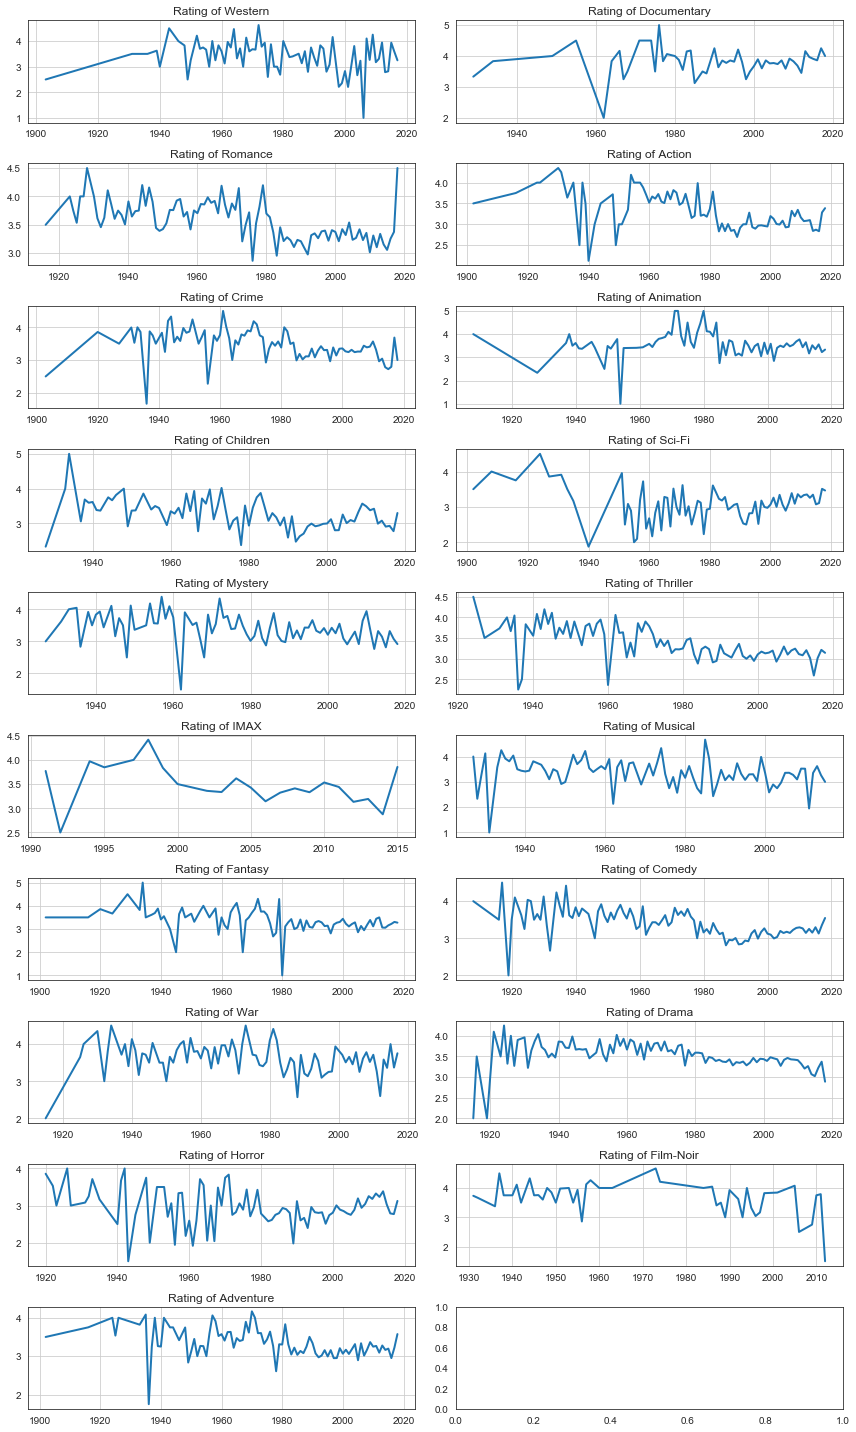

In [333]:
sub = movies[movies["year"]!=-1]
fig, axes = plt.subplots(10,2,figsize=(12,20))
for i, genre in  enumerate(genres, 1):
    genreMovies = sub[sub[genre]==1].groupby("year").mean()["rating"]
    axes[(i-1)//2, (i-1)%2].plot(genreMovies, linewidth=2.0)
    axes[(i-1)//2, (i-1)%2].title.set_text("Rating of %s"%genre)
    axes[(i-1)//2, (i-1)%2].grid(True)
fig.tight_layout()


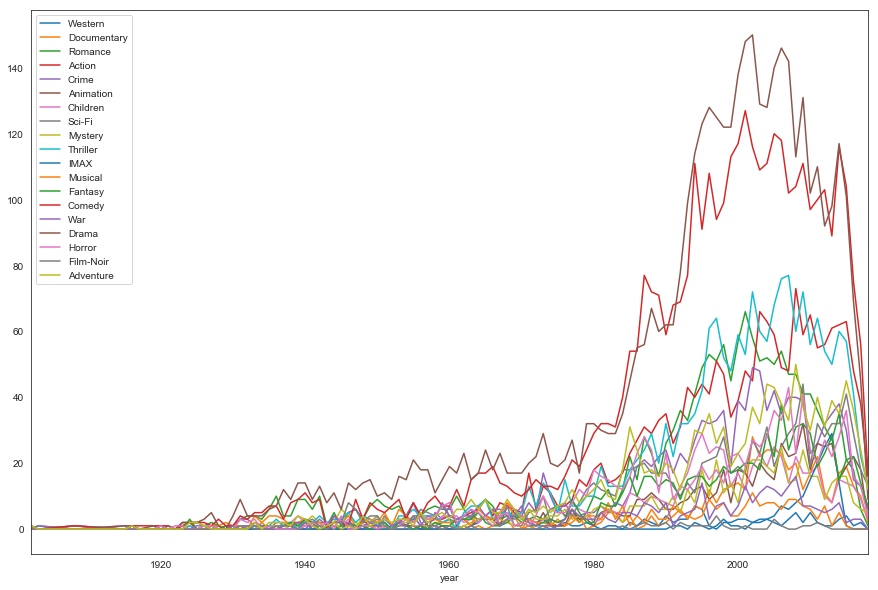

In [334]:
movies[movies["year"]!=-1].groupby(['year'])[list(genres)].sum().plot(figsize=(15,10))

In [340]:
movies[movies["year"]!=-1].groupby(['year'])[list(genres)].sum().tail(10)

,Western,Documentary,Romance,Action,Crime,Animation,Children,Sci-Fi,Mystery,Thriller,IMAX,Musical,Fantasy,Comedy,War,Drama,Horror,Film-Noir,Adventure
year,,,,,,,,,,,,,,,,,,,
2009,2,12,41,59,39,32,17,44,24,72,10,7,32,111,7,131,41,1,37
2010,5,17,41,65,23,18,17,19,16,56,15,6,29,97,7,102,24,1,30
2011,2,22,36,55,26,26,19,32,16,64,20,3,19,100,6,110,20,2,40
2012,1,11,31,56,32,25,10,28,9,54,25,7,23,103,5,92,27,1,31
2013,1,8,27,61,35,26,8,32,14,50,29,1,28,89,6,98,22,0,39
2014,3,17,35,62,38,15,15,32,16,60,14,5,15,116,8,117,28,0,35
2015,4,19,21,63,30,19,14,41,16,57,1,1,21,104,2,101,36,0,45
2016,1,13,18,48,15,22,13,29,8,41,0,0,22,75,3,69,16,0,36
2017,2,10,6,38,13,18,9,18,6,22,0,0,14,56,3,45,13,0,24


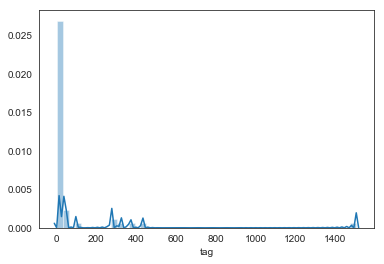

In [341]:
sns.distplot(tags.groupby("userId").count()["tag"])

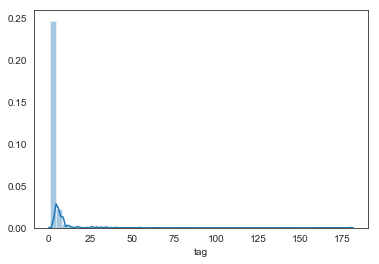

In [342]:
sns.distplot(tags.groupby("movieId").count()["tag"])

In [343]:
sub = tags.groupby("movieId").count()

In [344]:
movies = movies.merge(sub["tag"], on="movieId")

In [345]:
movies

,movieId,title,genres,ratingCount,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating,year,tag
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,215.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,3.920930,1995,3
1,2,Jumanji,Adventure|Children|Fantasy,110.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,3.431818,1995,4
2,3,Grumpier Old Men,Comedy|Romance,52.0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,3.259615,1995,2
3,5,Father of the Bride Part II,Comedy,49.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3.071429,1995,2
4,7,Sabrina,Comedy|Romance,54.0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,3.185185,1995,1
5,11,"American President, The",Comedy|Drama|Romance,70.0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,3.671429,1995,2
6,14,Nixon,Drama,18.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.833333,1995,2
7,16,Casino,Crime|Drama,82.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.926829,1995,1
8,17,Sense and Sensibility,Drama|Romance,67.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,3.776119,1995,1
9,21,Get Shorty,Comedy|Crime|Thriller,89.0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,3.494382,1995,1


In [346]:
tagCountBygenre = dict()
for genre in genres:
    tagCountBygenre[genre] = movies[movies[genre]==1]["tag"].sum()

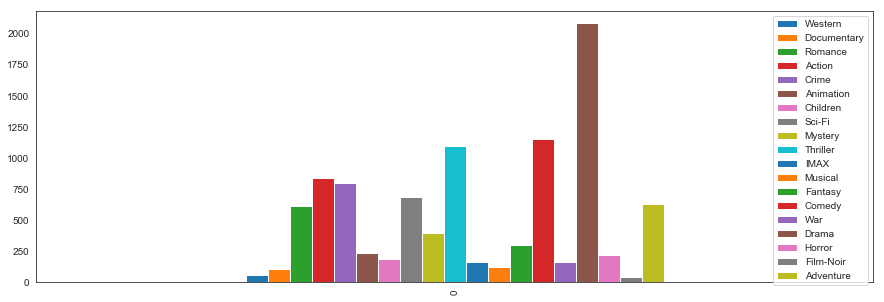

In [350]:
pd.DataFrame(tagCountBygenre, index=[0]).plot(kind="bar", figsize=(15,5))

In [351]:
movies

,movieId,title,genres,ratingCount,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating,year,tag
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,215.0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,3.920930,1995,3
1,2,Jumanji,Adventure|Children|Fantasy,110.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,3.431818,1995,4
2,3,Grumpier Old Men,Comedy|Romance,52.0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,3.259615,1995,2
3,5,Father of the Bride Part II,Comedy,49.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,3.071429,1995,2
4,7,Sabrina,Comedy|Romance,54.0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,3.185185,1995,1
5,11,"American President, The",Comedy|Drama|Romance,70.0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,3.671429,1995,2
6,14,Nixon,Drama,18.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.833333,1995,2
7,16,Casino,Crime|Drama,82.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.926829,1995,1
8,17,Sense and Sensibility,Drama|Romance,67.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,3.776119,1995,1
9,21,Get Shorty,Comedy|Crime|Thriller,89.0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,3.494382,1995,1
